In [14]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import LineString
from shapely.ops import linemerge
from utils import EarthquakeCatalog
from sklearn.neighbors import BallTree
from scipy.stats import bootstrap
import scipy.io
import h5py
from typing import Callable, Optional, List
import os
import math
import pyproj

font = {'size'   : 8}

matplotlib.rc('font', **font)

data_dir = "data/"

## Shapefile for the Greenland Coastline

In [15]:
gdf = gpd.read_file(os.path.join(data_dir,"Greenland_coast/Greenland_coast.shp"))

# Note that for simplicity I get rid of all islands. This could feasibly be improved by later simplifying the coastline geometry although I am not sure this is straightforward.
gdf = gdf.iloc[[gdf.area.argmax()]]

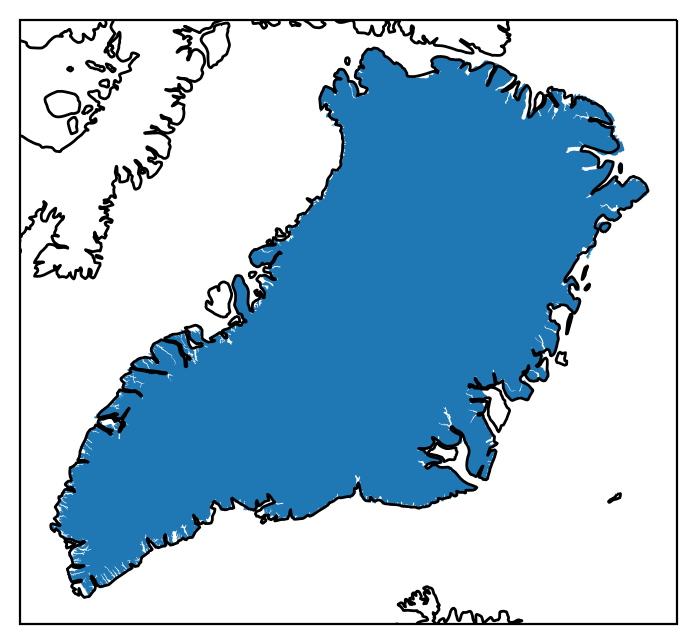

In [16]:
# crs are always a bit confusing: here we set axis and boundary geometry to
# the same north polar stereographic projection 
def plot_gdf(gdf,crs=ccrs.NorthPolarStereo(), ax=None, kwarg=None):
    if kwarg is None:
        kwarg = {}
    crs_proj4 = crs.proj4_init
    gdf_reprojected = gdf.geometry.to_crs(crs_proj4)
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection=crs),dpi=200)
    gdf_reprojected.plot(ax=ax, **kwarg)
    ax.coastlines()

plot_gdf(gdf)

## Entering Coordinate reference system hell

In [17]:
def densify_geometry(line_geometry, step, crs_in=None, crs_out=None):
    
    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m=line_geometry.length # get the length

    xy=[] # to store new tuples of coordinates

    for distance_along_old_line in np.arange(0,int(length_m),step): 

        point = line_geometry.interpolate(distance_along_old_line) # interpolate a point every step along the old line
        xp,yp = point.x, point.y # extract the coordinates

        xy.append((xp,yp)) # and store them in xy list

    new_line=LineString(xy) # Here, we finally create a new line with densified points.
    
    if crs_in != None:  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo=gpd.geoseries.GeoSeries(new_line,crs=crs_in)
    
    if crs_out != None:
        new_line_geo=new_line_geo.to_crs(crs_out)
        return new_line_geo

    else:
        return new_line

def merge_and_densify_geodataframe(gdf, step, crs_in=None, crs_out=None):
    
    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    gdf_densified = gdf.copy()
    gdf_densified = gdf_densified.to_crs(crs_in) 
    
    gdf_densified.geometry = gdf_densified.geometry.apply(lambda x: densify_geometry(x, step, crs_in, crs_out))
    
    return gdf_densified

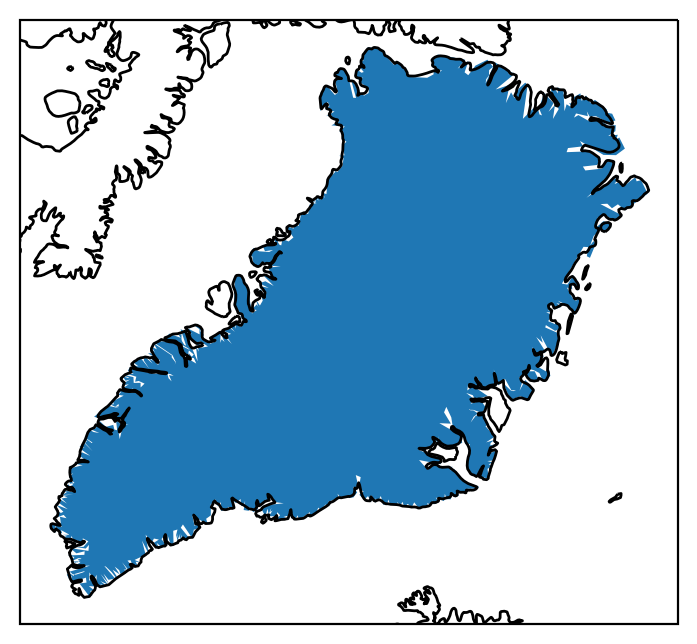

In [18]:
crs_out = 'EPSG:4326'
gdf_simplified = gdf.simplify(10000)
plot_gdf(gdf_simplified)
gdf_simplified = gdf_simplified.to_crs(crs_out)
preprocessed_geometry = gdf_simplified.geometry.values[0].exterior

In [19]:
gdf = gdf.to_crs(crs_out)
buffer = 5
bound_buffer = buffer*np.array([-1,-1,1,1])
bounds = np.array(gdf.total_bounds) + bound_buffer
print(
    'Total bounds of the selected plate boundary:\n{}'.format(
        bounds,
    )
)

Total bounds of the selected plate boundary:
[-78.02652108  54.97404364  -6.50473822  88.6598431 ]


## Get earthquakes for the corresponding region

In [20]:
MAGNITUDE_OF_COMPLETENESS = 4.0

reload_catalog = True
filename = "Greenland_catalog.csv"
if reload_catalog is True:
    bounds = bounds
    EarthquakeCatalog.get_and_save_catalog(
        filename = os.path.join(data_dir,filename),
        starttime = "1980-01-01",
        endtime = "2022-01-01",
        latitude_range = bounds[1::2],
        longitude_range = bounds[0::2],
        minimum_magnitude = MAGNITUDE_OF_COMPLETENESS,
    )

catalog = pd.read_csv(os.path.join(data_dir,filename), na_values=" None")
catalog = EarthquakeCatalog._add_time_column(catalog, "time")
catalog = catalog.sort_values(by="time", ascending=True, ignore_index=True)

Text(0.5, 0, 'Magnitude')

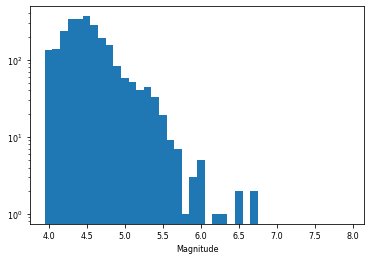

In [21]:
plt.hist(catalog["mag"], bins=np.arange(MAGNITUDE_OF_COMPLETENESS-0.05,8,0.1), log=True)
plt.xlabel("Magnitude")

## distance search

In [22]:
EARTH_RADIUS = 6371 # km 
def radius_search(points,queries,radius)->list[list]:
    """Searches for points within a radius of a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query_radius(np.deg2rad(queries),r=radius/EARTH_RADIUS,return_distance=False)

def k_nearest_search(points,queries,k):
    """Searches for k nearest points to a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric='haversine')
    return tree.query(np.deg2rad(queries),k=k)[1] 

def get_geometry_neighbors(
    catalog: pd.DataFrame,
    boundary: LineString,
    fun: Callable = radius_search,
    kwarg: dict = {"radius":100},
    return_unique: bool = False,
    ):
    """Returns a list of indices of earthquakes that are neighboring the the specified linestring geometry."""

    queries = np.array([boundary.xy[1], boundary.xy[0]]).T
    points = np.array([catalog.lat.to_numpy(),catalog.lon.to_numpy()]).T

    indices = fun(points,queries,**kwarg)

    if return_unique:
        indices = np.unique(np.concatenate(indices))
    
    return indices

## The plate boundary catalog

We can generate a subcatalog that follows the plate boundary with.

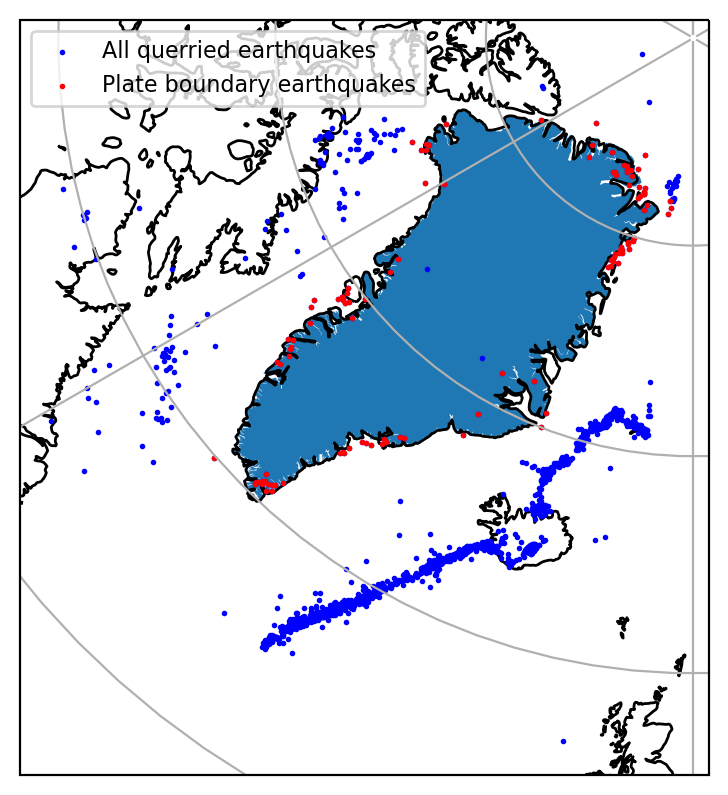

In [23]:
local_catalog = catalog.copy()
unique_indices = get_geometry_neighbors(catalog, preprocessed_geometry, fun=radius_search, kwarg={"radius":100}, return_unique=True)
local_catalog = local_catalog.iloc[unique_indices]

crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(5, 5), dpi=200)
plot_gdf(gdf,ax=ax)

ax.gridlines()

ax.scatter(x=catalog.lon.to_numpy(), y=catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='b', s=1, label="All querried earthquakes");
ax.scatter(x=local_catalog.lon.to_numpy(), y=local_catalog.lat.to_numpy(), transform=ccrs.PlateCarree(), color='r', s=1, label="Plate boundary earthquakes");
ax.legend();

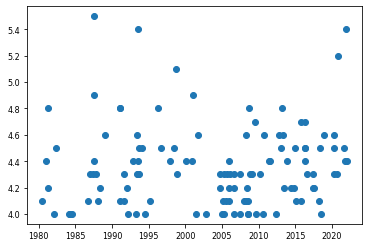

In [24]:
plt.scatter(local_catalog.time, local_catalog.mag)

# Greenland Icesheet Glacial Isostatic Ajustment model output

We can next consider how these rates of seismicity relate to changes in Iceshelf loading over time.

In [13]:
strain = scipy.io.loadmat(os.path.join(data_dir,'strain.mat'))['strain']
strain = np.flip(strain,1) # idk man, life is hard

FileNotFoundError: [Errno 2] No such file or directory: 'data/strain.mat'

In [ ]:
def get_data_from_querries(
    times: np.ndarray,
    latitudes: np.ndarray,
    longitudes: np.ndarray,
    dataset: np.ndarray = strain,
    data_times: np.ndarray =  1993+np.arange(27),
    data_latitudes: np.ndarray =  np.arange(510)/510 * 180 - 90,
    data_longitudes: np.ndarray =  np.arange(1022)/1022 * 360 - 180,
) -> np.ndarray:

    time_grid,lat_grid,lon_grid  = np.meshgrid(
        data_times,
        data_latitudes,
        data_longitudes,
        indexing='ij'
    )

    tree = BallTree(
        np.column_stack([
            time_grid.flatten(), 
            lat_grid.flatten(),
            lon_grid.flatten()
        ])
    )

    querried_indices = tree.query(
        np.column_stack([times, latitudes, longitudes],),
        k=1
    )[1] 

    return strain.reshape(-1, *strain.shape[-2:])[querried_indices,:,:].squeeze()

In [ ]:
earthquake_time_dt = pd.to_datetime(local_catalog.time).dt
strain_at_earthquake_with_time = get_data_from_querries(
    earthquake_time_dt.year + earthquake_time_dt.dayofyear/365-1,
    local_catalog.lat.to_numpy(),
    local_catalog.lon.to_numpy(),
);

minmax_vector = lambda x, N=500: np.linspace(x.min(), x.max(), N)
greenland_lat_grid, greenland_lon_grid, greenland_time_grid  = np.meshgrid(
    minmax_vector(local_catalog.lat),
    minmax_vector(local_catalog.lon),
    np.array([[2020]]),
    indexing='ij'
)

greenland_strain = get_data_from_querries(
    greenland_time_grid[:,:,0].flatten(),
    greenland_lat_grid[:,:,0].flatten(), 
    greenland_lon_grid[:,:,0].flatten(),
)

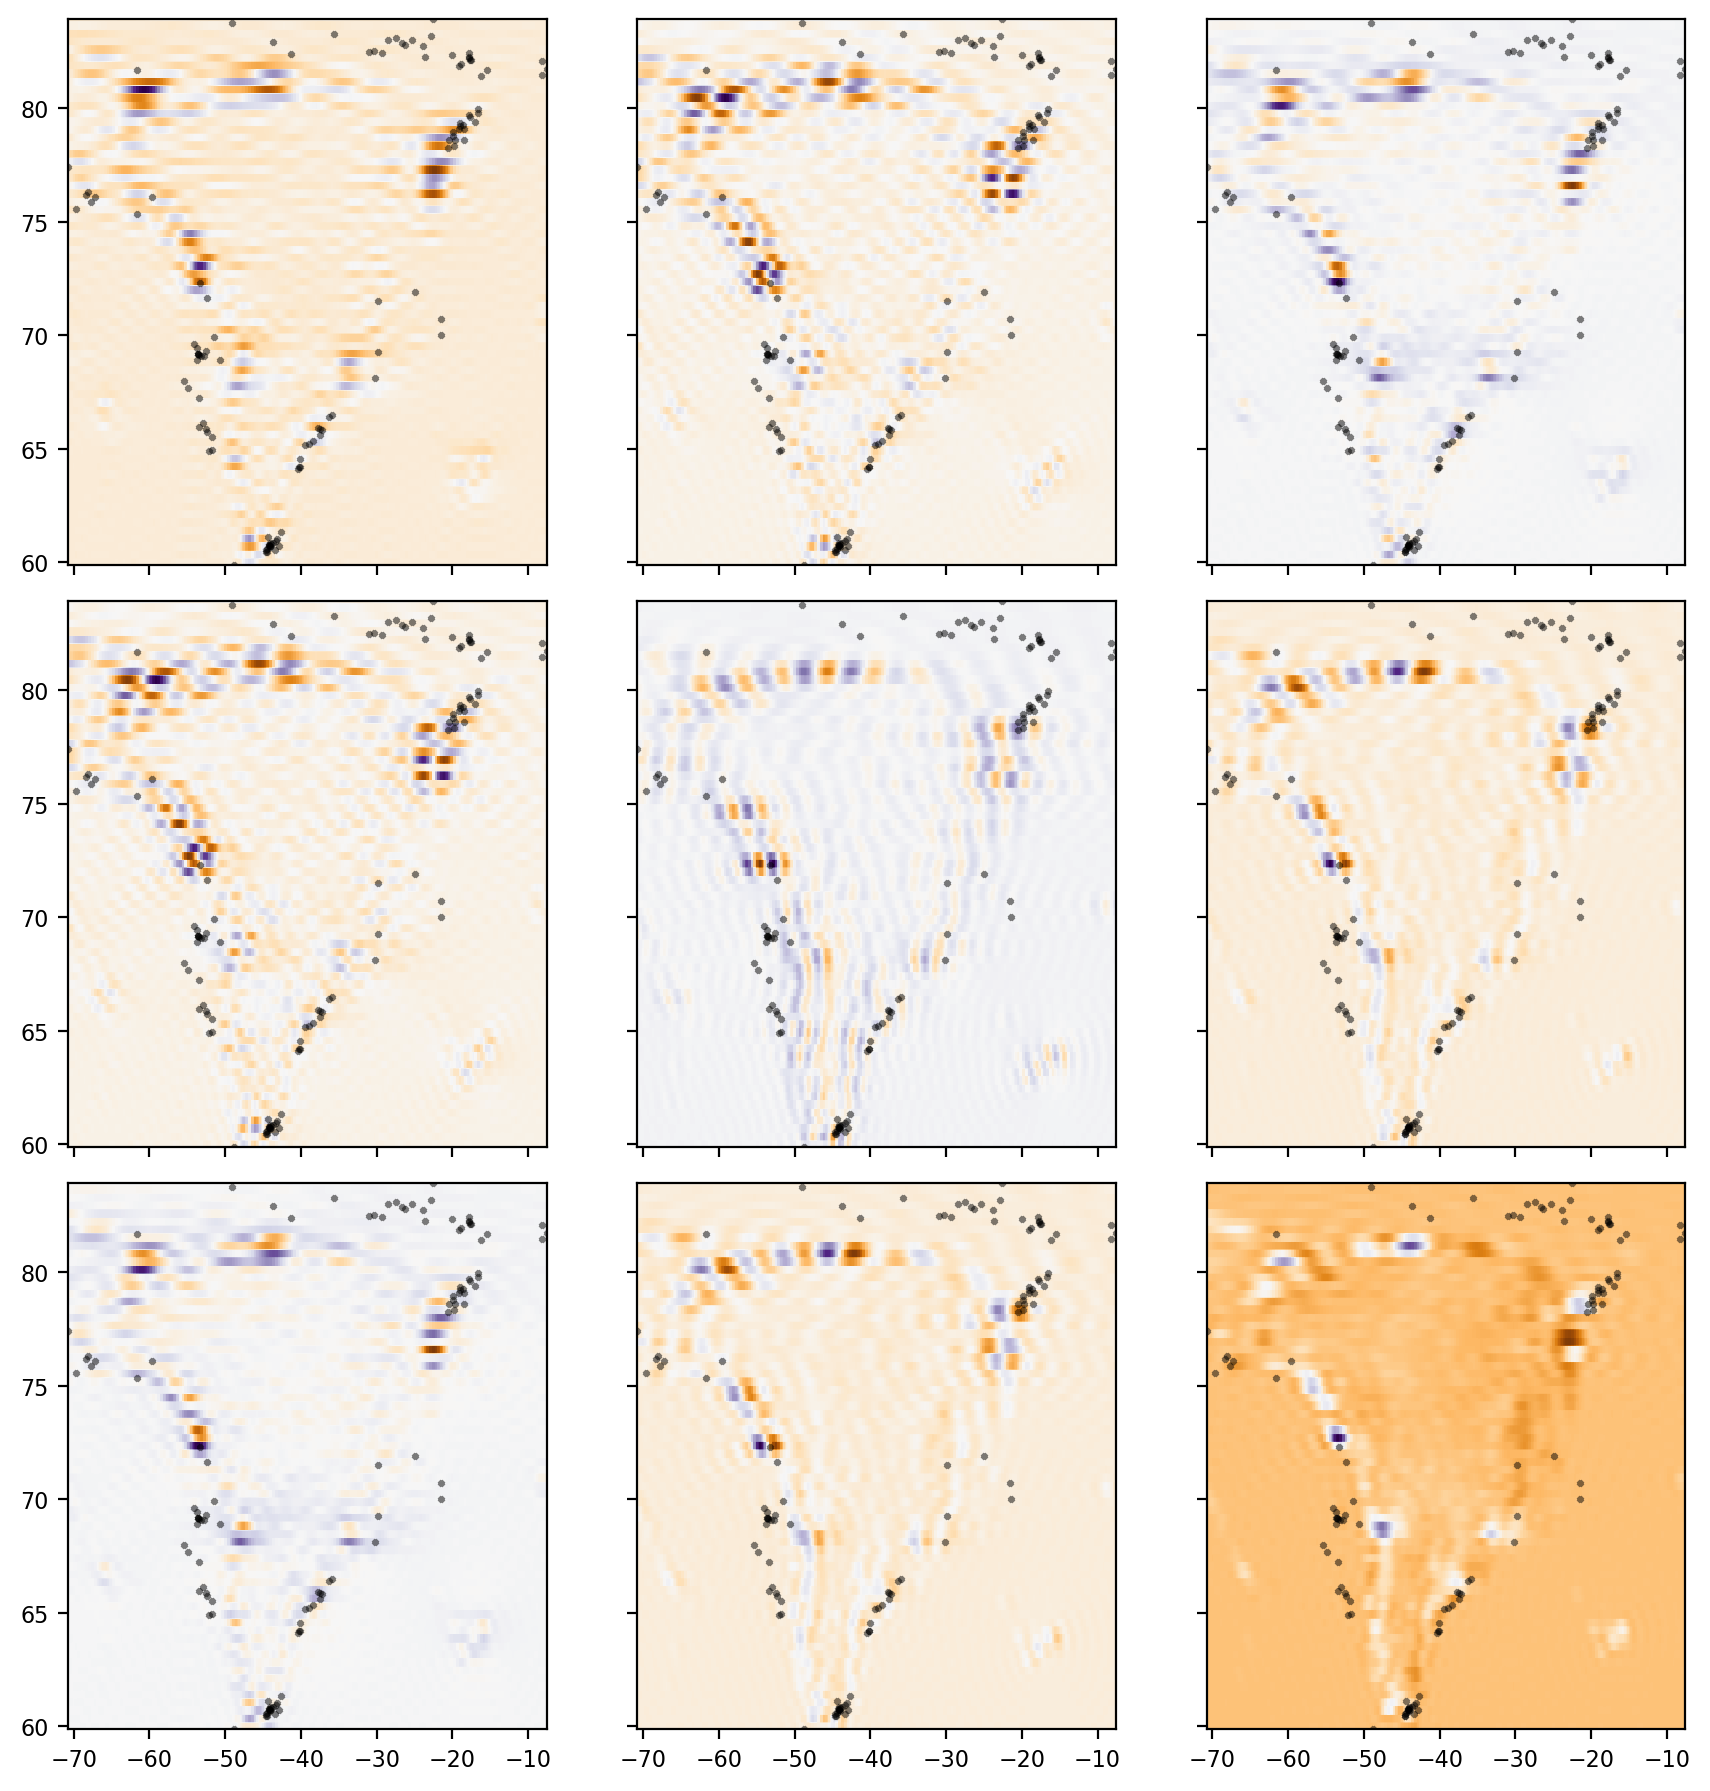

In [ ]:
greenland_strain.shape
greenland_strain_grid = np.reshape(greenland_strain,[*greenland_time_grid.shape, 3, 3])

fig, AX = plt.subplots(3,3,dpi=200, figsize=(9,9), sharex=True, sharey=True)

[AX[i,j].imshow(
    greenland_strain_grid[:,:,0,i,j],
    origin='lower',
    cmap='PuOr',
    extent=[
        np.min(local_catalog.lon),
        np.max(local_catalog.lon),
        np.min(local_catalog.lat),
        np.max(local_catalog.lat),
    ],
    aspect=3,
) for i in range(3) for j in range(3)]



[AX[i,j].scatter(
    local_catalog.lon,local_catalog.lat,marker='x',c='k',alpha=0.5,s=3
) for i in range(3) for j in range(3)]
plt.tight_layout()

**Figure**: GrGIA.

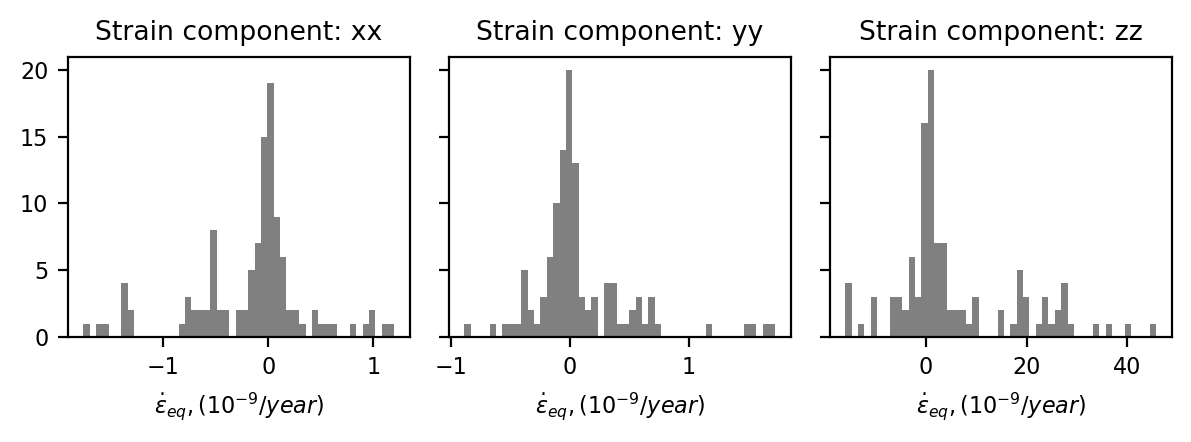

In [138]:
fig, ax = plt.subplots(1,3,figsize=(3*2,2.25),dpi=200, sharey=True)
bins = np.linspace(-0.2,0.2,50)
for ii, iax in enumerate(ax):
    range_95th_percentile = np.percentile(strain_at_earthquake_with_time[:,ii,ii],[2.5,97.5])
    iax.hist(strain_at_earthquake_with_time[:,ii,ii],
        bins=np.linspace(*range_95th_percentile,50),
        color='grey',
    )
    iax.set_xlabel(r'$\dot{\epsilon}_{eq}, (10^{-9}/year)$')
    iax.set_title(f"Strain component: {['xx','yy','zz'][ii]}")

plt.tight_layout()

**Figure**: GrGIA at earthquake locations